In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Delaware
state_ab = "de"

## Data
1. Download all the data in directory "de_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2022/DESenate22.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2022/March 2022 Redistricting Clean Up File.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|███████████████████████████████████| 20198/20198 [00:08<00:00, 2342.83it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 493.02it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['PRECINCT', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW',
       'G20USSDCOO', 'G20USSRWIT', 'G20USSLFRO', 'G20USSITUR', 'G20HALDROC',
       'G20HALRMUR', 'G20HALLROG', 'G20HALIPUR', 'G20GOVDCAR', 'G20GOVRMUR',
       'G20GOVLMAC', 'G20GOVIDEM', 'G20LTGDHAL', 'G20LTGRHAL', 'G20INSDNAV',
       'G20INSRPIL', 'geometry'],
      dtype='object')

In [23]:
start_col = 1
vest_base_data = vest20
year = '20'

In [24]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|████████████████████████████████████████████| 3/3 [00:00<00:00, 457.53it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00, 71.40it/s]


Identifying overlaps...


100%|█████████████████████████████████████| 3731/3731 [00:01<00:00, 3488.79it/s]


Resolving overlaps and filling gaps...


Gaps to fill in region 2: 100%|█████████████████| 12/12 [00:00<00:00, 35.31it/s]


In [25]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [26]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 434/434 [00:00<00:00, 4196.32it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|███████████████████████████████████████| 434/434 [00:00<00:00, 1393.93it/s]


In [27]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 434/434 [00:00<00:00, 1362.94it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [28]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 434/434 [00:01<00:00, 287.54it/s]


In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['GOV20D', 'GOV20O', 'GOV20R', 'HAL20D', 'HAL20O', 'HAL20R', 'INS20D',
       'INS20R', 'LTG20D', 'LTG20R', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT',
       'USS20D', 'USS20O', 'USS20R', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [34]:
vest18.columns

Index(['PRECINCT', 'G18USSDCAR', 'G18USSRARL', 'G18USSGTHE', 'G18USSLFRO',
       'G18HALDROC', 'G18HALRWAL', 'G18ATGDJEN', 'G18ATGRPEP', 'G18TREDDAV',
       'G18TRERSIM', 'G18TREGCHA', 'G18AUDDMCG', 'G18AUDRSPA', 'geometry'],
      dtype='object')

In [35]:
vest16.columns

Index(['PRECINCT', 'G16PREDCLI', 'G16PRERTRU', 'G16PREGSTE', 'G16PRELJOH',
       'G16HALDROC', 'G16HALRREI', 'G16HALGPER', 'G16HALLGES', 'G16GOVDCAR',
       'G16GOVRBON', 'G16GOVGGRO', 'G16GOVLGOW', 'G16LTGDHAL', 'G16LTGRGUN',
       'G16INSDNAV', 'G16INSRCRA', 'geometry'],
      dtype='object')

In [36]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 434/434 [00:00<00:00, 1367.94it/s]


There are 4 overlaps.
There are 2 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 439/439 [00:00<00:00, 3935.63it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 434/434 [00:01<00:00, 293.86it/s]


population agrees


In [37]:
election_df.columns

Index(['2MOREVAP', 'AMINVAP', 'ASIANVAP', 'ATG18D', 'ATG18R', 'AUD18D',
       'AUD18R', 'BVAP', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL18D', 'HAL18R',
       'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'INS20D',
       'INS20R', 'LTG20D', 'LTG20R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN',
       'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP',
       'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT', 'TOTPOP', 'TRE18D', 'TRE18O',
       'TRE18R', 'USS18D', 'USS18O', 'USS18R', 'USS20D', 'USS20O', 'USS20R',
       'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [38]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|████████████████████████████████████████| 434/434 [00:01<00:00, 292.00it/s]


population agrees


##  Add the district data

In [40]:
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [41]:
send.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJ_WHITE,ADJ_BLACK,ADJ_ASIAN,...,IDEAL_VALU,DEVIATION,F_DEVIATIO,F_ADJ_WHIT,F_ADJ_BLAC,F_ADJ_ASIA,F_ADJ_AMIN,F_ADJ_OTHE,DISTRICT_L,geometry
0,1,15.944303,1,1.0,None,None,44856,29399,10231,1640,...,47124.0,-2268.0,-0.048128,0.655408,0.228085,0.036561,0.001783,0.017657,1|-4.81%,"POLYGON ((459397.171 4404380.313, 459407.426 4..."
1,2,60.647408,10,1.0,None,None,47281,27975,10990,3724,...,47124.0,157.0,0.003332,0.591675,0.232440,0.078763,0.001819,0.027009,10|0.33%,"POLYGON ((439816.509 4362323.636, 439814.629 4..."
2,3,20.521450,11,1.0,None,None,48203,21537,14022,5115,...,47124.0,1079.0,0.022897,0.446798,0.290895,0.106114,0.004336,0.068149,11|2.29%,"POLYGON ((438586.106 4384502.738, 438450.437 4..."
3,4,107.664040,12,1.0,None,None,47368,26073,13463,2908,...,47124.0,244.0,0.005178,0.550435,0.284221,0.061392,0.002977,0.028247,12|0.52%,"POLYGON ((452064.837 4389531.217, 452193.392 4..."
4,5,15.994961,13,1.0,None,None,48294,18048,19838,2801,...,47124.0,1170.0,0.024828,0.373711,0.410776,0.057999,0.004410,0.072618,13|2.48%,"POLYGON ((449533.733 4393829.261, 449520.838 4..."


In [42]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 127.62it/s]


In [43]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,ADJ_POPULA,ADJ_WHITE,ADJ_BLACK,ADJ_ASIAN,...,TOTAL_REGI,DEM_,REP_,OTHER_,F_ADJ_18_W,F_ADJ_18_B,F_ADJ_18_A,DISTRICT_N,DISTRICT_L,geometry
0,1,2.455995,01,1.0,None,None,23267,6608,14503,313,...,19374,0.754878,0.085114,0.160008,0.317962,0.598196,0.014487,1,01|-3.6%,"POLYGON ((452589.776 4401467.362, 452595.695 4..."
1,2,10.331964,02,1.0,None,None,22961,5099,13969,351,...,17218,0.719422,0.087118,0.193460,0.258801,0.586316,0.018915,2,02|-4.87%,"POLYGON ((452782.874 4398517.819, 452781.591 4..."
2,3,1.584466,03,1.0,None,None,23692,6461,11869,200,...,16771,0.721543,0.093614,0.184843,0.308913,0.484878,0.010081,3,03|-1.84%,"POLYGON ((452680.649 4399561.647, 452687.138 4..."
3,4,52.090076,04,1.0,None,None,23653,19435,1249,300,...,19540,0.356704,0.399846,0.243449,0.853769,0.047228,0.011489,4,04|-2.01%,"POLYGON ((489146.820 4281322.915, 489194.103 4..."
4,5,5.388244,05,1.0,None,None,23485,6842,11952,1312,...,16989,0.677262,0.122609,0.200129,0.321194,0.493084,0.058338,5,05|-2.7%,"POLYGON ((448148.122 4390793.016, 447973.272 4..."


In [44]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 172.83it/s]


In [45]:
maup.doctor(election_df)

100%|███████████████████████████████████████| 434/434 [00:00<00:00, 1259.71it/s]


True

### Put the base precinct year after the precinct information column

In [46]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'VTDST':'VTDST'+year,
        'NAME':'NAME'+year}
election_df.rename(columns=base_columns, inplace = True)

In [49]:
list(election_df.columns)

['2MOREVAP',
 'AMINVAP',
 'ASIANVAP',
 'ATG18D',
 'ATG18R',
 'AUD18D',
 'AUD18R',
 'BVAP',
 'GOV16D',
 'GOV16O',
 'GOV16R',
 'GOV20D',
 'GOV20O',
 'GOV20R',
 'HAL16D',
 'HAL16O',
 'HAL16R',
 'HAL18D',
 'HAL18R',
 'HAL20D',
 'HAL20O',
 'HAL20R',
 'HISP',
 'HVAP',
 'H_2MORE',
 'H_AMIN',
 'H_ASIAN',
 'H_BLACK',
 'H_NHPI',
 'H_OTHER',
 'H_WHITE',
 'INS16D',
 'INS16R',
 'INS20D',
 'INS20R',
 'LTG16D',
 'LTG16R',
 'LTG20D',
 'LTG20R',
 'NHPIVAP',
 'NH_2MORE',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_BLACK',
 'NH_NHPI',
 'NH_OTHER',
 'NH_WHITE',
 'OTHERVAP',
 'PRE16D',
 'PRE16O',
 'PRE16R',
 'PRE20D',
 'PRE20O',
 'PRE20R',
 'PRECINCT',
 'TOTPOP',
 'TRE18D',
 'TRE18O',
 'TRE18R',
 'USS18D',
 'USS18O',
 'USS18R',
 'USS20D',
 'USS20O',
 'USS20R',
 'VAP',
 'WVAP',
 'geometry',
 'SEND',
 'HDIST']

In [51]:
base_columns = {
    'PRECINCT':'PRECINCT'+year,
}
election_df.rename(columns=base_columns, inplace = True)

In [52]:
# reorder the columns
fixed_columns = [
    'PRECINCT'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [53]:
import os

# store the result in directory "de"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

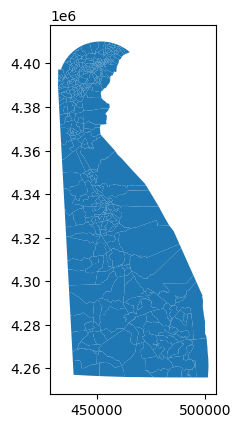

In [54]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()